## Return Analysis and Visualization

The `analyze_and_plot_returns` function evaluates and compares portfolio strategies by:

### **Features**
- Dynamically loading daily return CSVs for multiple strategies.
- Computing performance statistics using `pyfolio`.
- Plotting cumulative return curves for visual comparison.

### **Inputs**
- `base_folder`: Directory containing subfolders for each strategy's return CSV.

### **Outputs**
- Printed performance metrics per strategy.
- Cumulative return comparison plot.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from finrl.plot import convert_daily_return_to_pyfolio_ts
from pyfolio import timeseries
import os
%matplotlib inline


def analyze_and_plot_returns(base_folder):
    # Define subfolders and filenames
    paths = {
        'A2C': f"{base_folder}/a2c/a2c_daily_return.csv",
        'DDPG': f"{base_folder}/ddpg/ddpg_daily_return.csv",
        'PPO': f"{base_folder}/ppo/ppo_daily_return.csv",
        'SAC': f"{base_folder}/sac/sac_daily_return.csv",
        'TD3': f"{base_folder}/td3/td3_daily_return.csv",
        'Ensemble': f"{base_folder}/df_daily_return_ensemble.csv",
        'Naive': f"{base_folder}/naive/df_daily_return_naive.csv",
        'Min': f"{base_folder}/min/df_daily_return_min.csv",
        'Mean': f"{base_folder}/mvo/df_daily_return_mvo.csv",
        'Adaptive-Mean': f"{base_folder}/adaptive_mvo/df_daily_return_adaptive_mvo.csv"
    }

    return_dfs = []
    agent_names = []

    # Load CSV files dynamically
    for name, path in paths.items():
        if os.path.exists(path):
            df = pd.read_csv(path, parse_dates=["date"])
            return_dfs.append(df)
            agent_names.append(name)
        else:
            print(f"[Warning] File not found for {name}: {path}")

    # Calculate and print performance stats
    for i, df_return in enumerate(return_dfs):
        strat = convert_daily_return_to_pyfolio_ts(df_return)
        stats = timeseries.perf_stats(strat)
        print(f"\nPerformance Stats for {agent_names[i]}:\n")
        print(stats)

    # Plot cumulative return
    plt.figure(figsize=(14, 7))
    for df, name in zip(return_dfs, agent_names):
        strat = convert_daily_return_to_pyfolio_ts(df)
        cum_return = (1 + strat).cumprod() - 1
        plt.plot(cum_return.index, cum_return.values, label=name)

    plt.title("Cumulative Return Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/opt/anaconda3/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(



Performance Stats for A2C:

Annual return           0.080268
Cumulative returns      0.167337
Annual volatility       0.104357
Sharpe ratio            0.791922
Calmar ratio            0.725894
Stability               0.875583
Max drawdown           -0.110578
Omega ratio             1.151984
Sortino ratio           1.166179
Skew                    0.550803
Kurtosis               12.080176
Tail ratio              0.953721
Daily value at risk    -0.012820
dtype: float64

Performance Stats for DDPG:

Annual return           0.088283
Cumulative returns      0.184759
Annual volatility       0.098642
Sharpe ratio            0.906894
Calmar ratio            0.929913
Stability               0.892646
Max drawdown           -0.094937
Omega ratio             1.176589
Sortino ratio           1.349757
Skew                    0.652174
Kurtosis               12.828532
Tail ratio              1.030663
Daily value at risk    -0.012073
dtype: float64

Performance Stats for PPO:

Annual return           

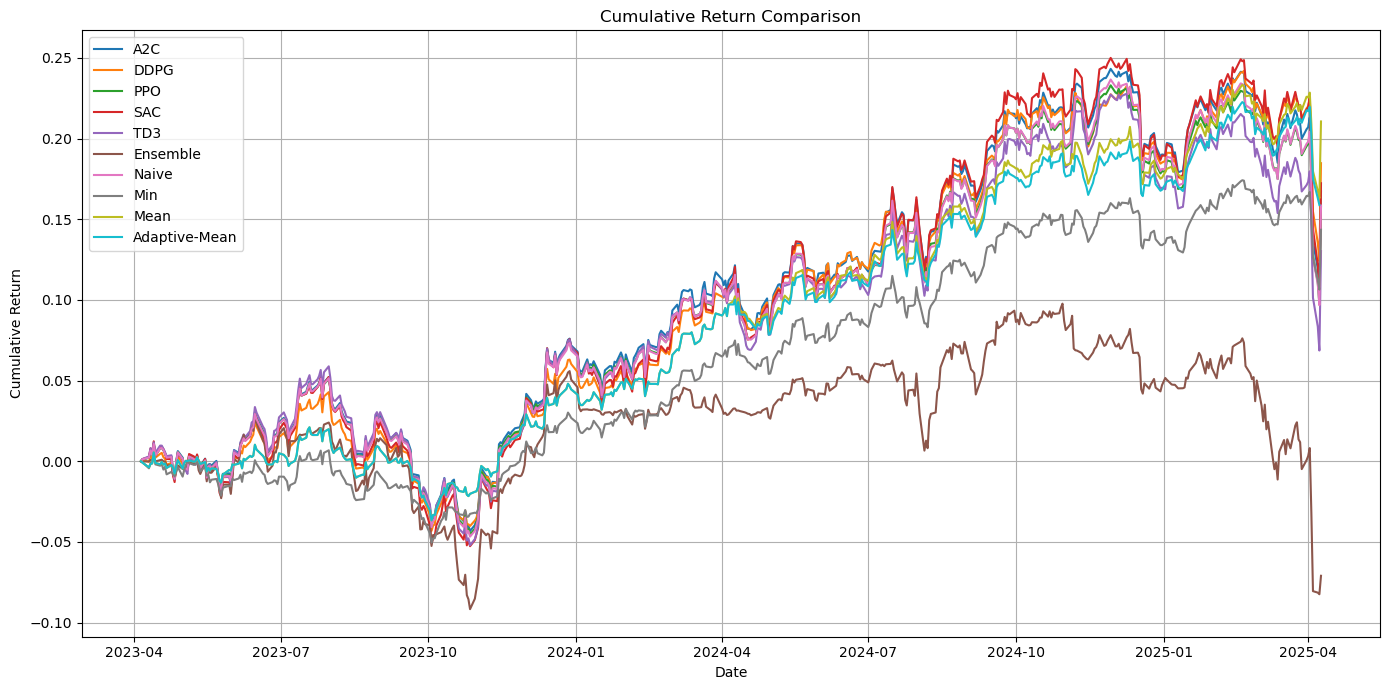

In [2]:
analyze_and_plot_returns(base_folder="2007-2025_no_crypto")



Performance Stats for A2C:

Annual return          0.170305
Cumulative returns     0.370469
Annual volatility      0.130218
Sharpe ratio           1.272869
Calmar ratio           1.365191
Stability              0.922232
Max drawdown          -0.124748
Omega ratio            1.241423
Sortino ratio          1.970784
Skew                   0.462455
Kurtosis               5.476530
Tail ratio             1.235035
Daily value at risk   -0.015748
dtype: float64

Performance Stats for DDPG:

Annual return          0.171861
Cumulative returns     0.374122
Annual volatility      0.126863
Sharpe ratio           1.313671
Calmar ratio           1.569345
Stability              0.928982
Max drawdown          -0.109511
Omega ratio            1.249247
Sortino ratio          2.021897
Skew                   0.342736
Kurtosis               4.641874
Tail ratio             1.186131
Daily value at risk   -0.015322
dtype: float64

Performance Stats for PPO:

Annual return          0.145244
Cumulative returns

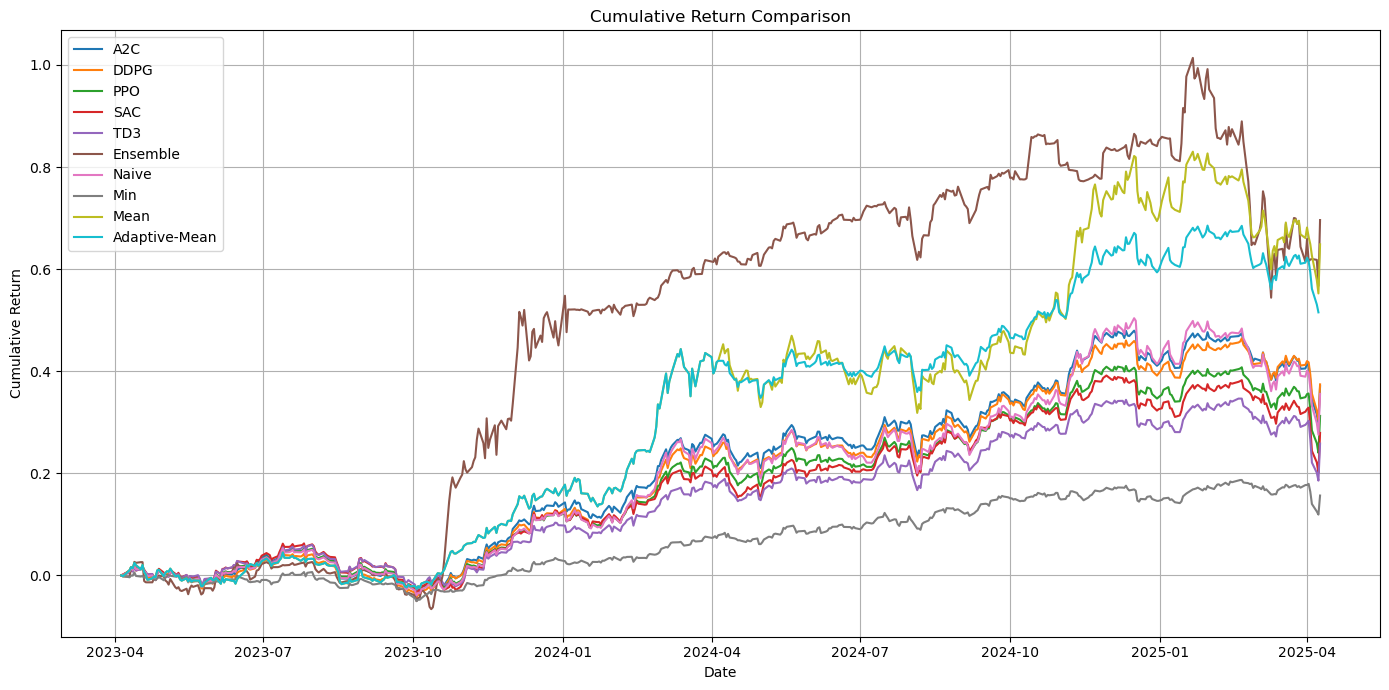

In [3]:
analyze_and_plot_returns(base_folder="2015-2025_crypto")



Performance Stats for A2C:

Annual return           0.066754
Cumulative returns      0.138255
Annual volatility       0.114700
Sharpe ratio            0.620537
Calmar ratio            0.496785
Stability               0.843230
Max drawdown           -0.134371
Omega ratio             1.116421
Sortino ratio           0.910267
Skew                    0.577871
Kurtosis               11.833729
Tail ratio              0.951443
Daily value at risk    -0.014168
dtype: float64

Performance Stats for DDPG:

Annual return          0.056474
Cumulative returns     0.116380
Annual volatility      0.109446
Sharpe ratio           0.556501
Calmar ratio           0.445907
Stability              0.821561
Max drawdown          -0.126649
Omega ratio            1.102912
Sortino ratio          0.813390
Skew                   0.487371
Kurtosis               9.761227
Tail ratio             0.955580
Daily value at risk   -0.013547
dtype: float64

Performance Stats for PPO:

Annual return           0.075920
Cumu

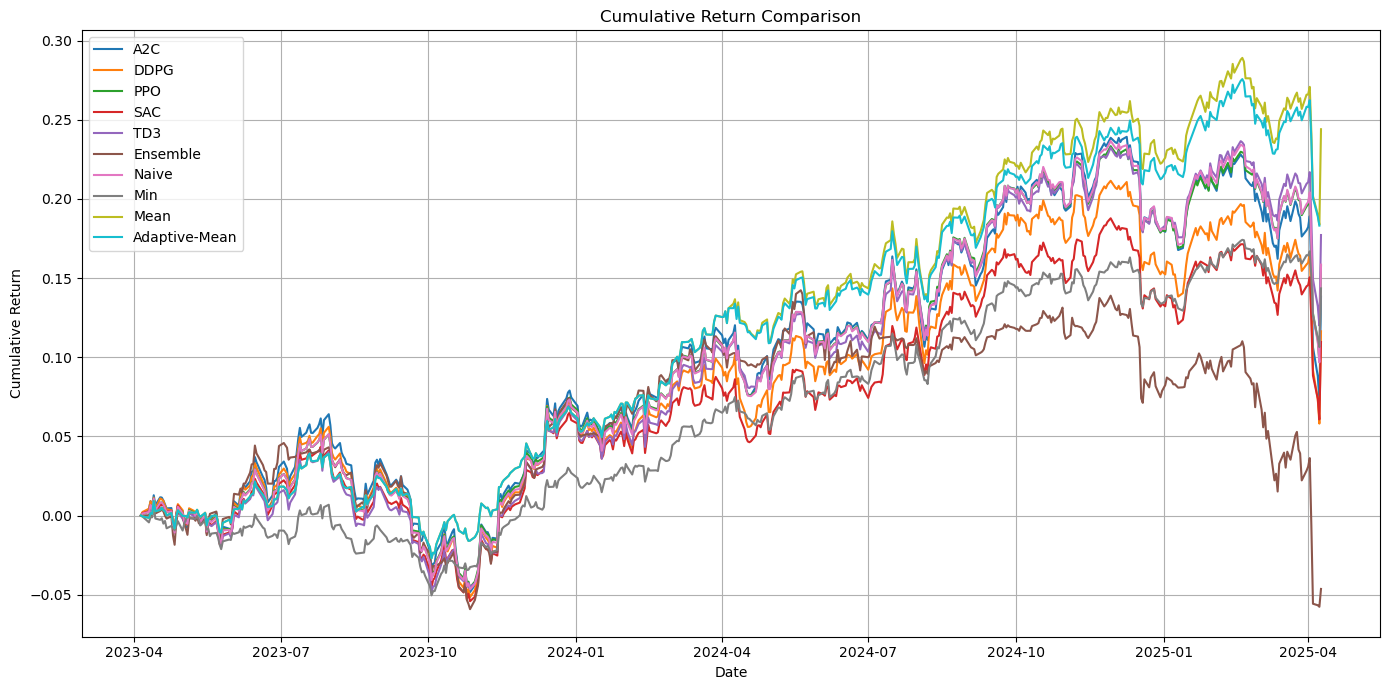

In [4]:
analyze_and_plot_returns(base_folder="2015-2025_no_crypto")


## Trading Behavior Analysis

The script evaluates trading patterns across different strategies by calculating:

### **Metrics**
- **Trade Frequency (%)**:  
  Percentage of days with position changes.
- **Average Holding Period (days)**:  
  Average number of days assets are held before rebalancing.

### **Functions**
- `analyze_positions(df)`:  
  Computes trade frequency and holding period from position data.
  
- `check_trading_behavior(base_folder)`:  
  Analyzes DRL models, traditional strategies (Naive, MVO, Min-Var), and merged trades within a given folder.

### **Outputs**
- Prints a summary DataFrame.
- Saves results as `trading_behavior_summary.csv` in the specified `base_folder`.


In [5]:
import pandas as pd
import numpy as np
import os

def analyze_positions(df, date_column='date'):
    if date_column in df.columns:
        df = df.sort_values(date_column).reset_index(drop=True)
        positions = df.drop(columns=[date_column])
    else:
        positions = df.copy()

    total_days = len(positions)
    position_changes = (positions.diff().abs().sum(axis=1) > 1e-6).astype(int)
    trade_days = position_changes.sum()
    trade_frequency = trade_days / total_days * 100

    holding_periods = {asset: [] for asset in positions.columns}
    for asset in positions.columns:
        hold_count = 1
        prev_position = positions.iloc[0][asset]
        for i in range(1, total_days):
            current_position = positions.iloc[i][asset]
            if abs(current_position - prev_position) < 1e-6:
                hold_count += 1
            else:
                holding_periods[asset].append(hold_count)
                hold_count = 1
            prev_position = current_position
        holding_periods[asset].append(hold_count)

    overall_avg_holding = np.mean([np.mean(periods) for periods in holding_periods.values()])
    return round(trade_frequency, 2), round(overall_avg_holding, 2)

def check_trading_behavior(base_folder):
    drl_algorithms = ['a2c', 'ddpg', 'ppo', 'sac', 'td3']
    strategies = {
        'Naive': "naive/df_positions_naive.csv",
        'Mean': "mvo/df_positions_mvo.csv",
        'Adaptive-Mean': "adaptive_mvo/df_positions_adaptive_mvo.csv"
    }

    results = []

    # 1. DRL Algorithms
    for algo in drl_algorithms:
        path = f"{base_folder}/{algo}/{algo}_actions.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            trade_freq, avg_hold = analyze_positions(df)
            results.append({
                "Category": "DRL",
                "Strategy": algo.upper(),
                "Trade Frequency (%)": trade_freq,
                "Avg Holding Period (days)": avg_hold
            })

    # 2. Strategies
    for strat_name, rel_path in strategies.items():
        path = f"{base_folder}/{rel_path}"
        if os.path.exists(path):
            df = pd.read_csv(path)
            trade_freq, avg_hold = analyze_positions(df, date_column='date')
            results.append({
                "Category": "Rules",
                "Strategy": strat_name,
                "Trade Frequency (%)": trade_freq,
                "Avg Holding Period (days)": avg_hold
            })

    # 3. Min-Variance
    min_path = f"{base_folder}/min/df_positions_min.csv"
    if os.path.exists(min_path):
        df = pd.read_csv(min_path)
        trade_freq, avg_hold = analyze_positions(df, date_column='date')
        results.append({
            "Category": "Rules",
            "Strategy": "Min-Var",
            "Trade Frequency (%)": trade_freq,
            "Avg Holding Period (days)": avg_hold
        })

    # 4. Merged Trade Actions
    merged_path = f"{base_folder}/merged_trade_actions.csv"
    if os.path.exists(merged_path):
        df = pd.read_csv(merged_path)
        trade_freq, avg_hold = analyze_positions(df, date_column='date')
        results.append({
            "Category": "DRL",
            "Strategy": "Ensemble",
            "Trade Frequency (%)": trade_freq,
            "Avg Holding Period (days)": avg_hold
        })

    # Output Summary
    df_summary = pd.DataFrame(results)
    print(f"\n=== Trading Behavior Summary for {base_folder} ===")
    print(df_summary)

    # Optional: Save
    output_path = f"{base_folder}/trading_behavior_summary.csv"
    df_summary.to_csv(output_path, index=False)
    print(f"[INFO] Summary saved to {output_path}")




In [6]:
check_trading_behavior("2007-2025_no_crypto")    



=== Trading Behavior Summary for 2007-2025_no_crypto ===
  Category       Strategy  Trade Frequency (%)  Avg Holding Period (days)
0      DRL            A2C                93.07                       1.13
1      DRL           DDPG                 0.20                     252.50
2      DRL            PPO                87.13                       1.21
3      DRL            SAC                 0.20                     252.50
4      DRL            TD3                 0.20                     252.50
5    Rules          Naive                 0.00                     505.00
6    Rules           Mean                 0.00                     505.00
7    Rules  Adaptive-Mean                 0.20                     441.00
8    Rules        Min-Var                98.02                     191.74
9      DRL       Ensemble                32.74                       4.76
[INFO] Summary saved to 2007-2025_no_crypto/trading_behavior_summary.csv


In [7]:
check_trading_behavior("2015-2025_crypto")


=== Trading Behavior Summary for 2015-2025_crypto ===
  Category       Strategy  Trade Frequency (%)  Avg Holding Period (days)
0      DRL            A2C                 5.35                      18.04
1      DRL           DDPG                 0.20                     252.50
2      DRL            PPO                15.84                       6.66
3      DRL            SAC                 0.20                     252.50
4      DRL            TD3                 0.20                     252.50
5    Rules          Naive                 0.00                     505.00
6    Rules           Mean                 0.00                     505.00
7    Rules  Adaptive-Mean                 0.20                     448.00
8    Rules        Min-Var                99.60                     171.49
9      DRL       Ensemble                35.91                       5.22
[INFO] Summary saved to 2015-2025_crypto/trading_behavior_summary.csv


In [8]:
check_trading_behavior("2015-2025_no_crypto")


=== Trading Behavior Summary for 2015-2025_no_crypto ===
  Category       Strategy  Trade Frequency (%)  Avg Holding Period (days)
0      DRL            A2C                63.17                       1.76
1      DRL           DDPG                 0.20                     252.50
2      DRL            PPO                90.69                       1.19
3      DRL            SAC                 0.20                     252.50
4      DRL            TD3                 0.20                     252.50
5    Rules          Naive                 0.00                     505.00
6    Rules           Mean                 0.00                     505.00
7    Rules  Adaptive-Mean                 0.20                     441.00
8    Rules        Min-Var                98.02                     191.74
9      DRL       Ensemble                47.82                       2.97
[INFO] Summary saved to 2015-2025_no_crypto/trading_behavior_summary.csv
